In [13]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import boxcox

s3 = boto3.resource('s3')
bucket_name = 'grant-gonnerman-data-445'
bucket = s3.Bucket(bucket_name)

file_key = 'train.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

file_key2 = 'test.csv'

bucket_object2 = bucket.Object(file_key2)
file_object2 = bucket_object2.get()
file_content_stream2 = file_object2.get('Body')

# reading data file
train = pd.read_csv(file_content_stream, delimiter = '|')
test = pd.read_csv(file_content_stream2, delimiter = '|')
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


<AxesSubplot: >

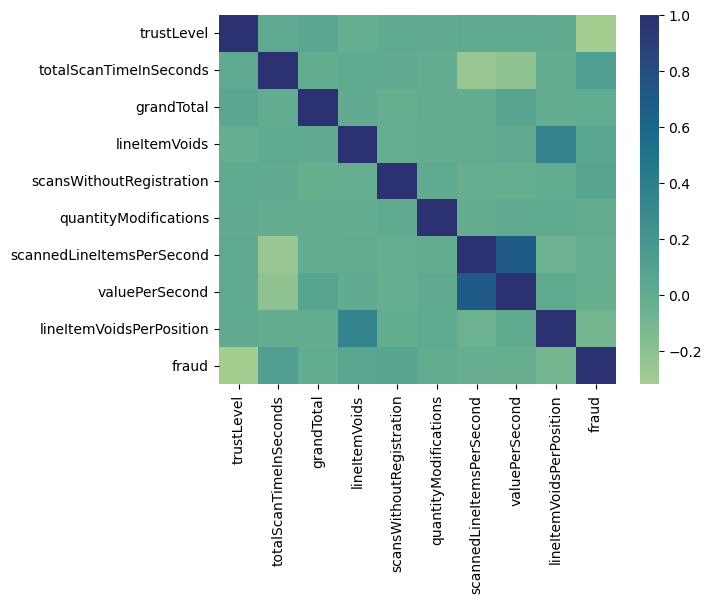

In [14]:
sns.heatmap(train.corr(), cmap="crest")

In [ ]:
## Noteworthy correlations ##

# totalScanTimeInSeconds X scannedLineItemsPerSecond
# totalScanTimeInSeconds X valuePerSecond
# grandTotal X valuePerSecond
# lineItemVoids X lineItemVoidsPerPosition
# scannedLineItemsPerSecond X valuePerSecond
# scannedLineItemsPerSecond X lineItemVoidsPerPosition

# Engineering features

In [15]:
# box cox transformation
transformed_lineItemVoidsPerPosition = boxcox(train['totalScanTimeInSeconds'])
train['totalScanTimeInSeconds'] = transformed_lineItemVoidsPerPosition[0]

transformed_lineItemVoidsPerPosition = boxcox(test['totalScanTimeInSeconds'])
test['totalScanTimeInSeconds'] = transformed_lineItemVoidsPerPosition[0]

# engineering interactions
train['interaction_1'] = train['totalScanTimeInSeconds'] * train['scannedLineItemsPerSecond']
train['interaction_2'] = train['totalScanTimeInSeconds'] * train['valuePerSecond']
train['interaction_3'] = train['grandTotal'] * train['valuePerSecond']
train['interaction_4'] = train['lineItemVoids'] * train['lineItemVoidsPerPosition']
train['interaction_5'] = train['scannedLineItemsPerSecond'] * train['valuePerSecond']
train['interaction_6'] = train['scannedLineItemsPerSecond'] * train['lineItemVoidsPerPosition']

test['interaction_1'] = test['totalScanTimeInSeconds'] * test['scannedLineItemsPerSecond']
test['interaction_2'] = test['totalScanTimeInSeconds'] * test['valuePerSecond']
test['interaction_3'] = test['grandTotal'] * test['valuePerSecond']
test['interaction_4'] = test['lineItemVoids'] * test['lineItemVoidsPerPosition']
test['interaction_5'] = test['scannedLineItemsPerSecond'] * test['valuePerSecond']
test['interaction_6'] = test['scannedLineItemsPerSecond'] * test['lineItemVoidsPerPosition']

In [16]:
# defining input and target variables
x = train.drop(columns = 'fraud')
y = train['fraud']

# list to store coefficents 
rf_importances = list()

for i in range(0, 100):
    # splitting the data into train and test 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, stratify = y)

    # building RF model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(x_train, y_train)
    # extracting importances
    rf_importances.append(rf_md.feature_importances_)
    
rf_results = pd.DataFrame(rf_importances)
rf_results.columns = [x] 

avg_importance = pd.DataFrame({'RF Importance': np.mean(rf_results)})
avg_importance = avg_importance.sort_values(by = 'RF Importance', ascending = False)
avg_importance

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,RF Importance
trustLevel,0.313823
interaction_1,0.172235
scannedLineItemsPerSecond,0.104105
totalScanTimeInSeconds,0.080228
lineItemVoidsPerPosition,0.057828
valuePerSecond,0.042901
interaction_5,0.040082
interaction_4,0.038122
grandTotal,0.033746
interaction_3,0.029726


In [17]:
# engineering by strong heredity
train['heredity_1'] = train['trustLevel'] * train['interaction_1']
train['heredity_2'] = train['trustLevel'] * train['scannedLineItemsPerSecond']
train['heredity_3'] = train['interaction_1'] * train['scannedLineItemsPerSecond']

test['heredity_1'] = test['trustLevel'] * test['interaction_1']
test['heredity_2'] = test['trustLevel'] * test['scannedLineItemsPerSecond']
test['heredity_3'] = test['interaction_1'] * test['scannedLineItemsPerSecond']

[Text(0.5769230769230769, 0.875, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.3076923076923077, 0.625, 'heredity_1 <= 4.139\ngini = 0.375\nsamples = 272\nvalue = [204, 68]'),
 Text(0.15384615384615385, 0.375, 'totalScanTimeInSeconds <= 281.406\ngini = 0.085\nsamples = 158\nvalue = [151, 7]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.0\nsamples = 124\nvalue = [124, 0]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.327\nsamples = 34\nvalue = [27, 7]'),
 Text(0.46153846153846156, 0.375, 'totalScanTimeInSeconds <= 182.28\ngini = 0.498\nsamples = 114\nvalue = [53, 61]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.371\nsamples = 65\nvalue = [49, 16]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.15\nsamples = 49\nvalue = [4, 45]'),
 Text(0.8461538461538461, 0.625, 'trustLevel <= 2.5\ngini = 0.024\nsamples = 1231\nvalue = [1216, 15]'),
 Text(0.7692307692307693, 0.375, 'interaction_1 <= 4.535\ngini = 0.102\nsamples = 278\nvalue = [263, 15]'),
 Text(0.69230

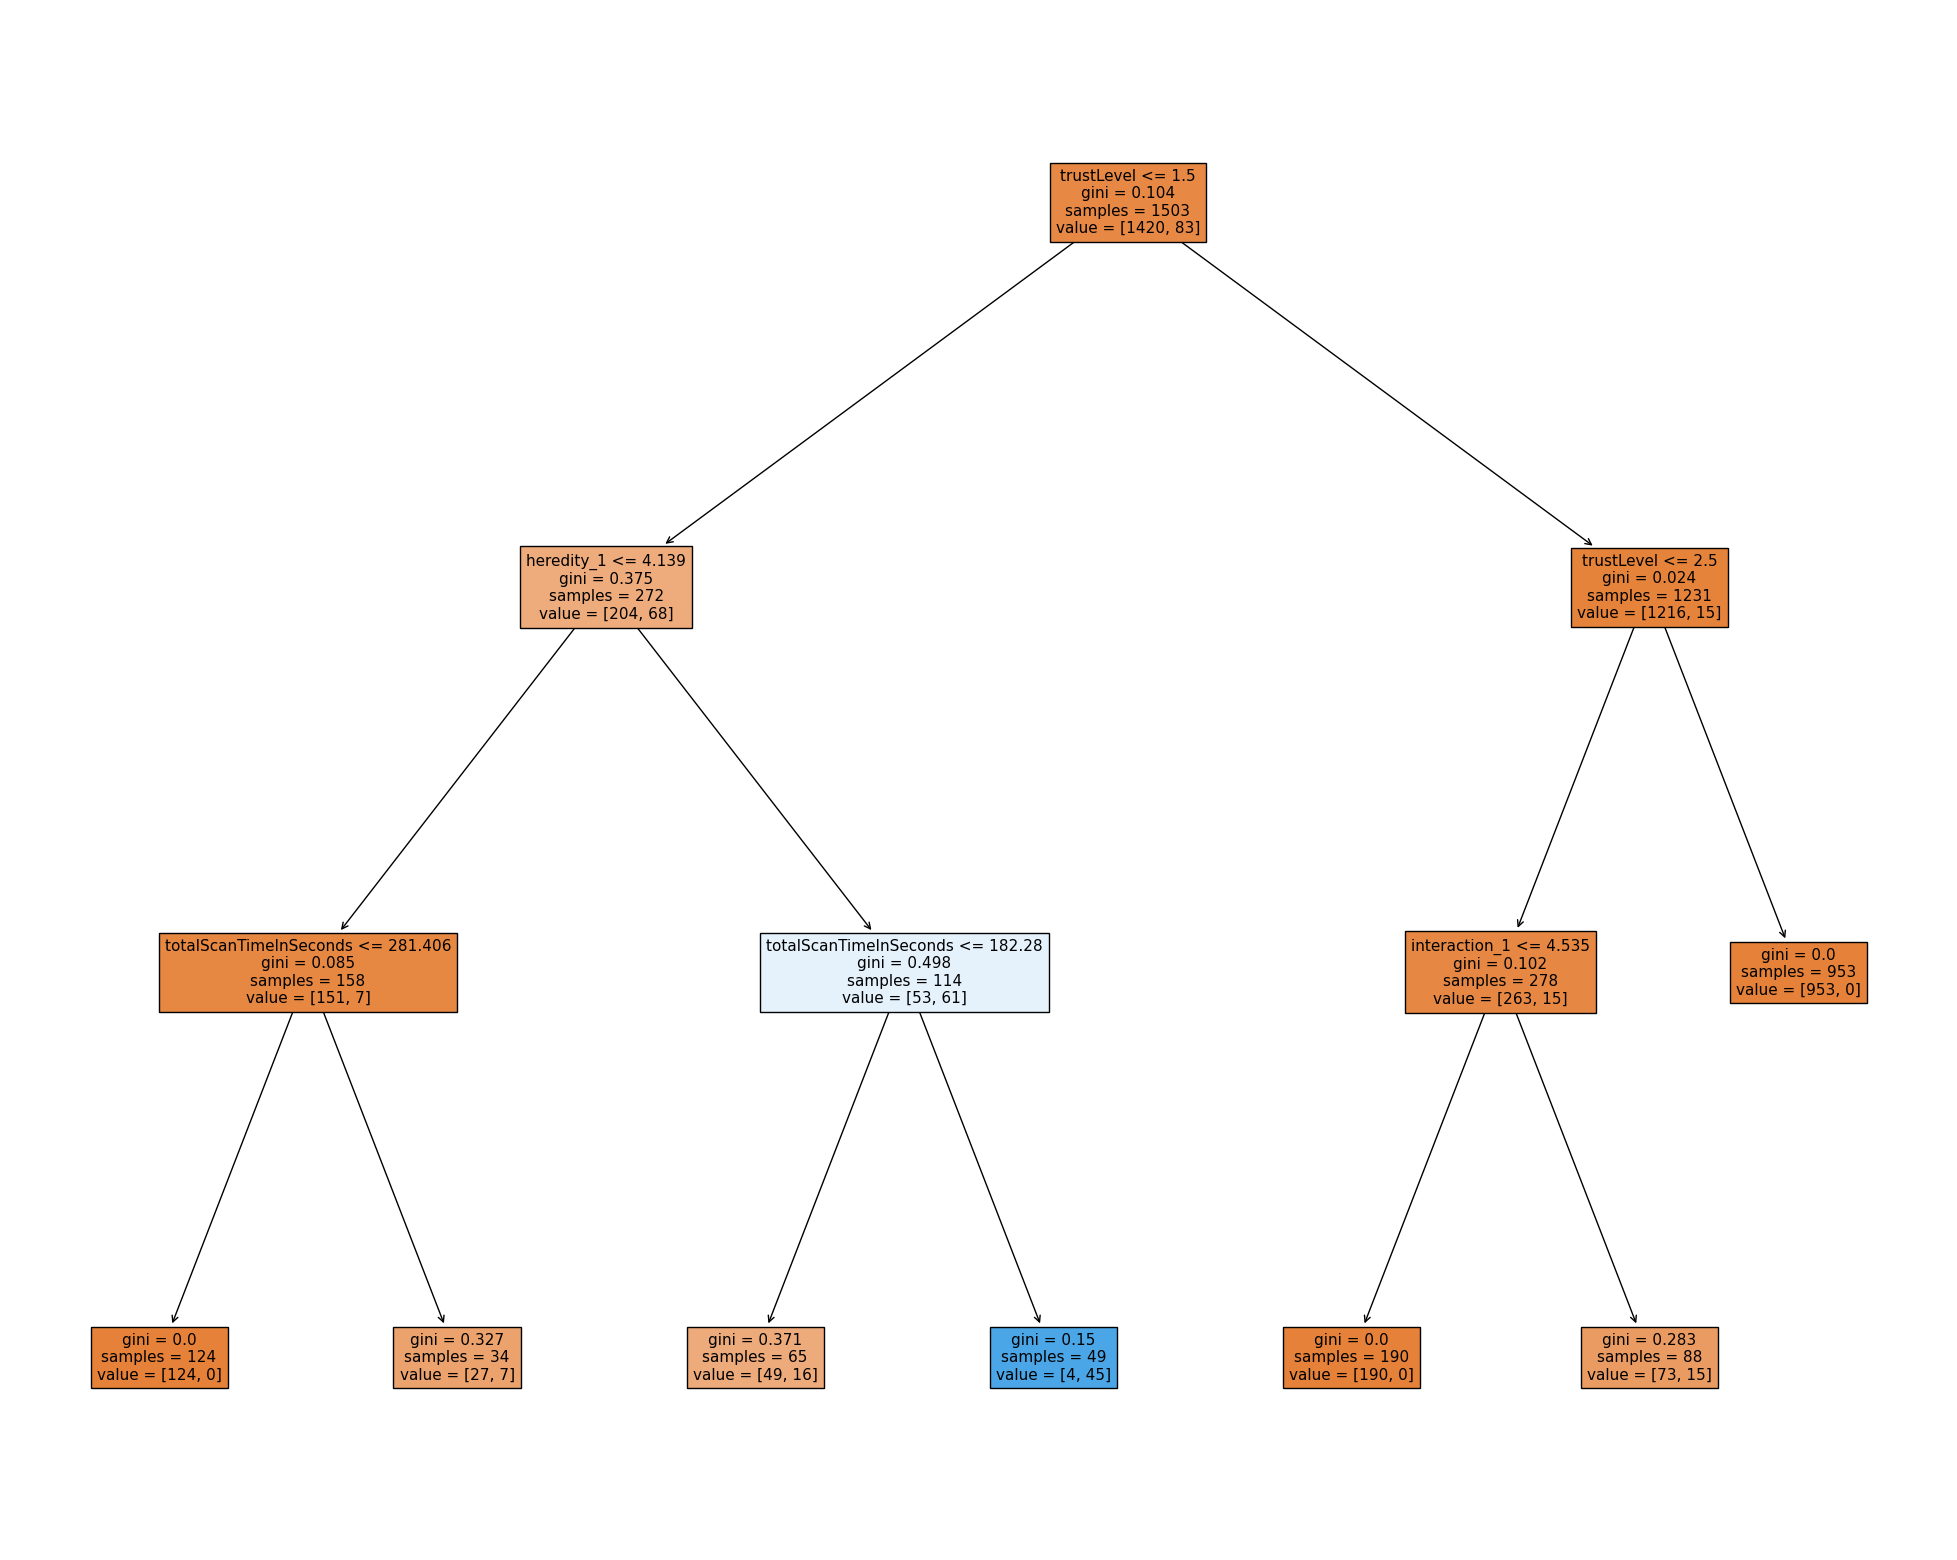

In [18]:
# defining input and target variables
x = train.drop(columns = 'fraud', axis = 1)
y = train['fraud']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

# building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5769230769230769, 0.875, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.3076923076923077, 0.625, 'interaction_1 <= 4.401\ngini = 0.391\nsamples = 270\nvalue = [198, 72]'),
 Text(0.15384615384615385, 0.375, 'totalScanTimeInSeconds <= 275.218\ngini = 0.091\nsamples = 167\nvalue = [159, 8]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.0\nsamples = 129\nvalue = [129, 0]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.332\nsamples = 38\nvalue = [30, 8]'),
 Text(0.46153846153846156, 0.375, 'totalScanTimeInSeconds <= 138.53\ngini = 0.471\nsamples = 103\nvalue = [39, 64]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.375\nsamples = 48\nvalue = [36, 12]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.103\nsamples = 55\nvalue = [3, 52]'),
 Text(0.8461538461538461, 0.625, 'trustLevel <= 2.5\ngini = 0.018\nsamples = 1233\nvalue = [1222, 11]'),
 Text(0.7692307692307693, 0.375, 'heredity_1 <= 9.257\ngini = 0.076\nsamples = 278\nvalue = [267, 11]'),
 Text(0.6923

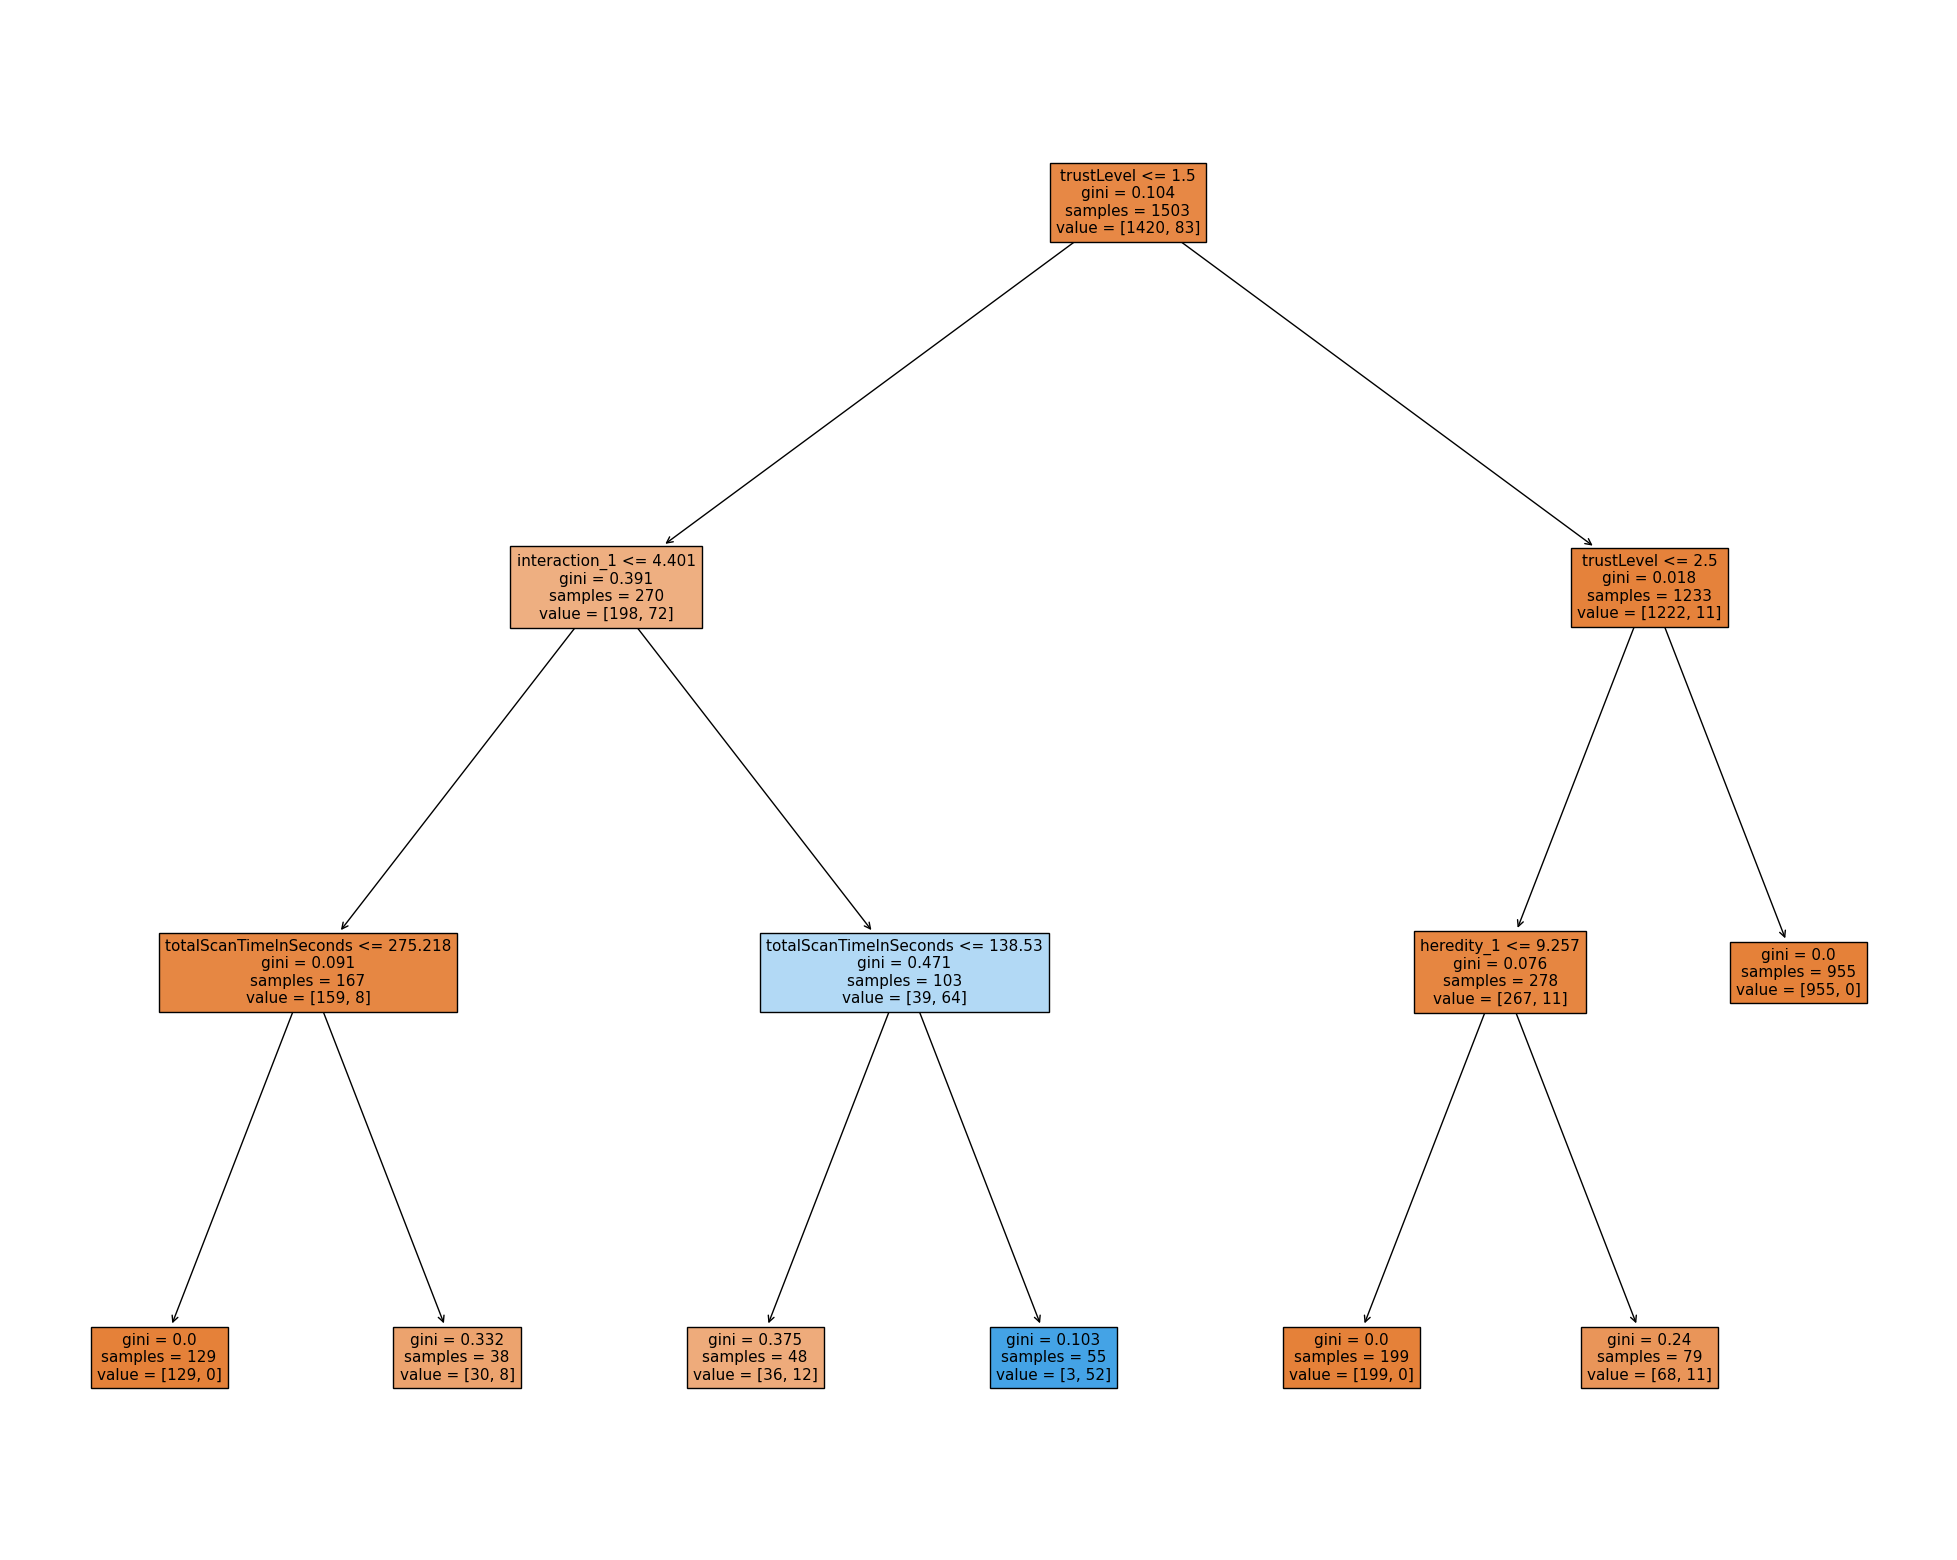

In [19]:
# defining input and target variables
x = train.drop(columns = 'fraud', axis = 1)
y = train['fraud']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

# building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5769230769230769, 0.875, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.3076923076923077, 0.625, 'heredity_1 <= 4.412\ngini = 0.392\nsamples = 265\nvalue = [194, 71]'),
 Text(0.15384615384615385, 0.375, 'totalScanTimeInSeconds <= 281.406\ngini = 0.095\nsamples = 160\nvalue = [152, 8]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.0\nsamples = 126\nvalue = [126, 0]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.36\nsamples = 34\nvalue = [26, 8]'),
 Text(0.46153846153846156, 0.375, 'totalScanTimeInSeconds <= 138.347\ngini = 0.48\nsamples = 105\nvalue = [42, 63]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.365\nsamples = 50\nvalue = [38, 12]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.135\nsamples = 55\nvalue = [4, 51]'),
 Text(0.8461538461538461, 0.625, 'trustLevel <= 2.5\ngini = 0.019\nsamples = 1238\nvalue = [1226, 12]'),
 Text(0.7692307692307693, 0.375, 'interaction_1 <= 4.535\ngini = 0.082\nsamples = 280\nvalue = [268, 12]'),
 Text(0.69230

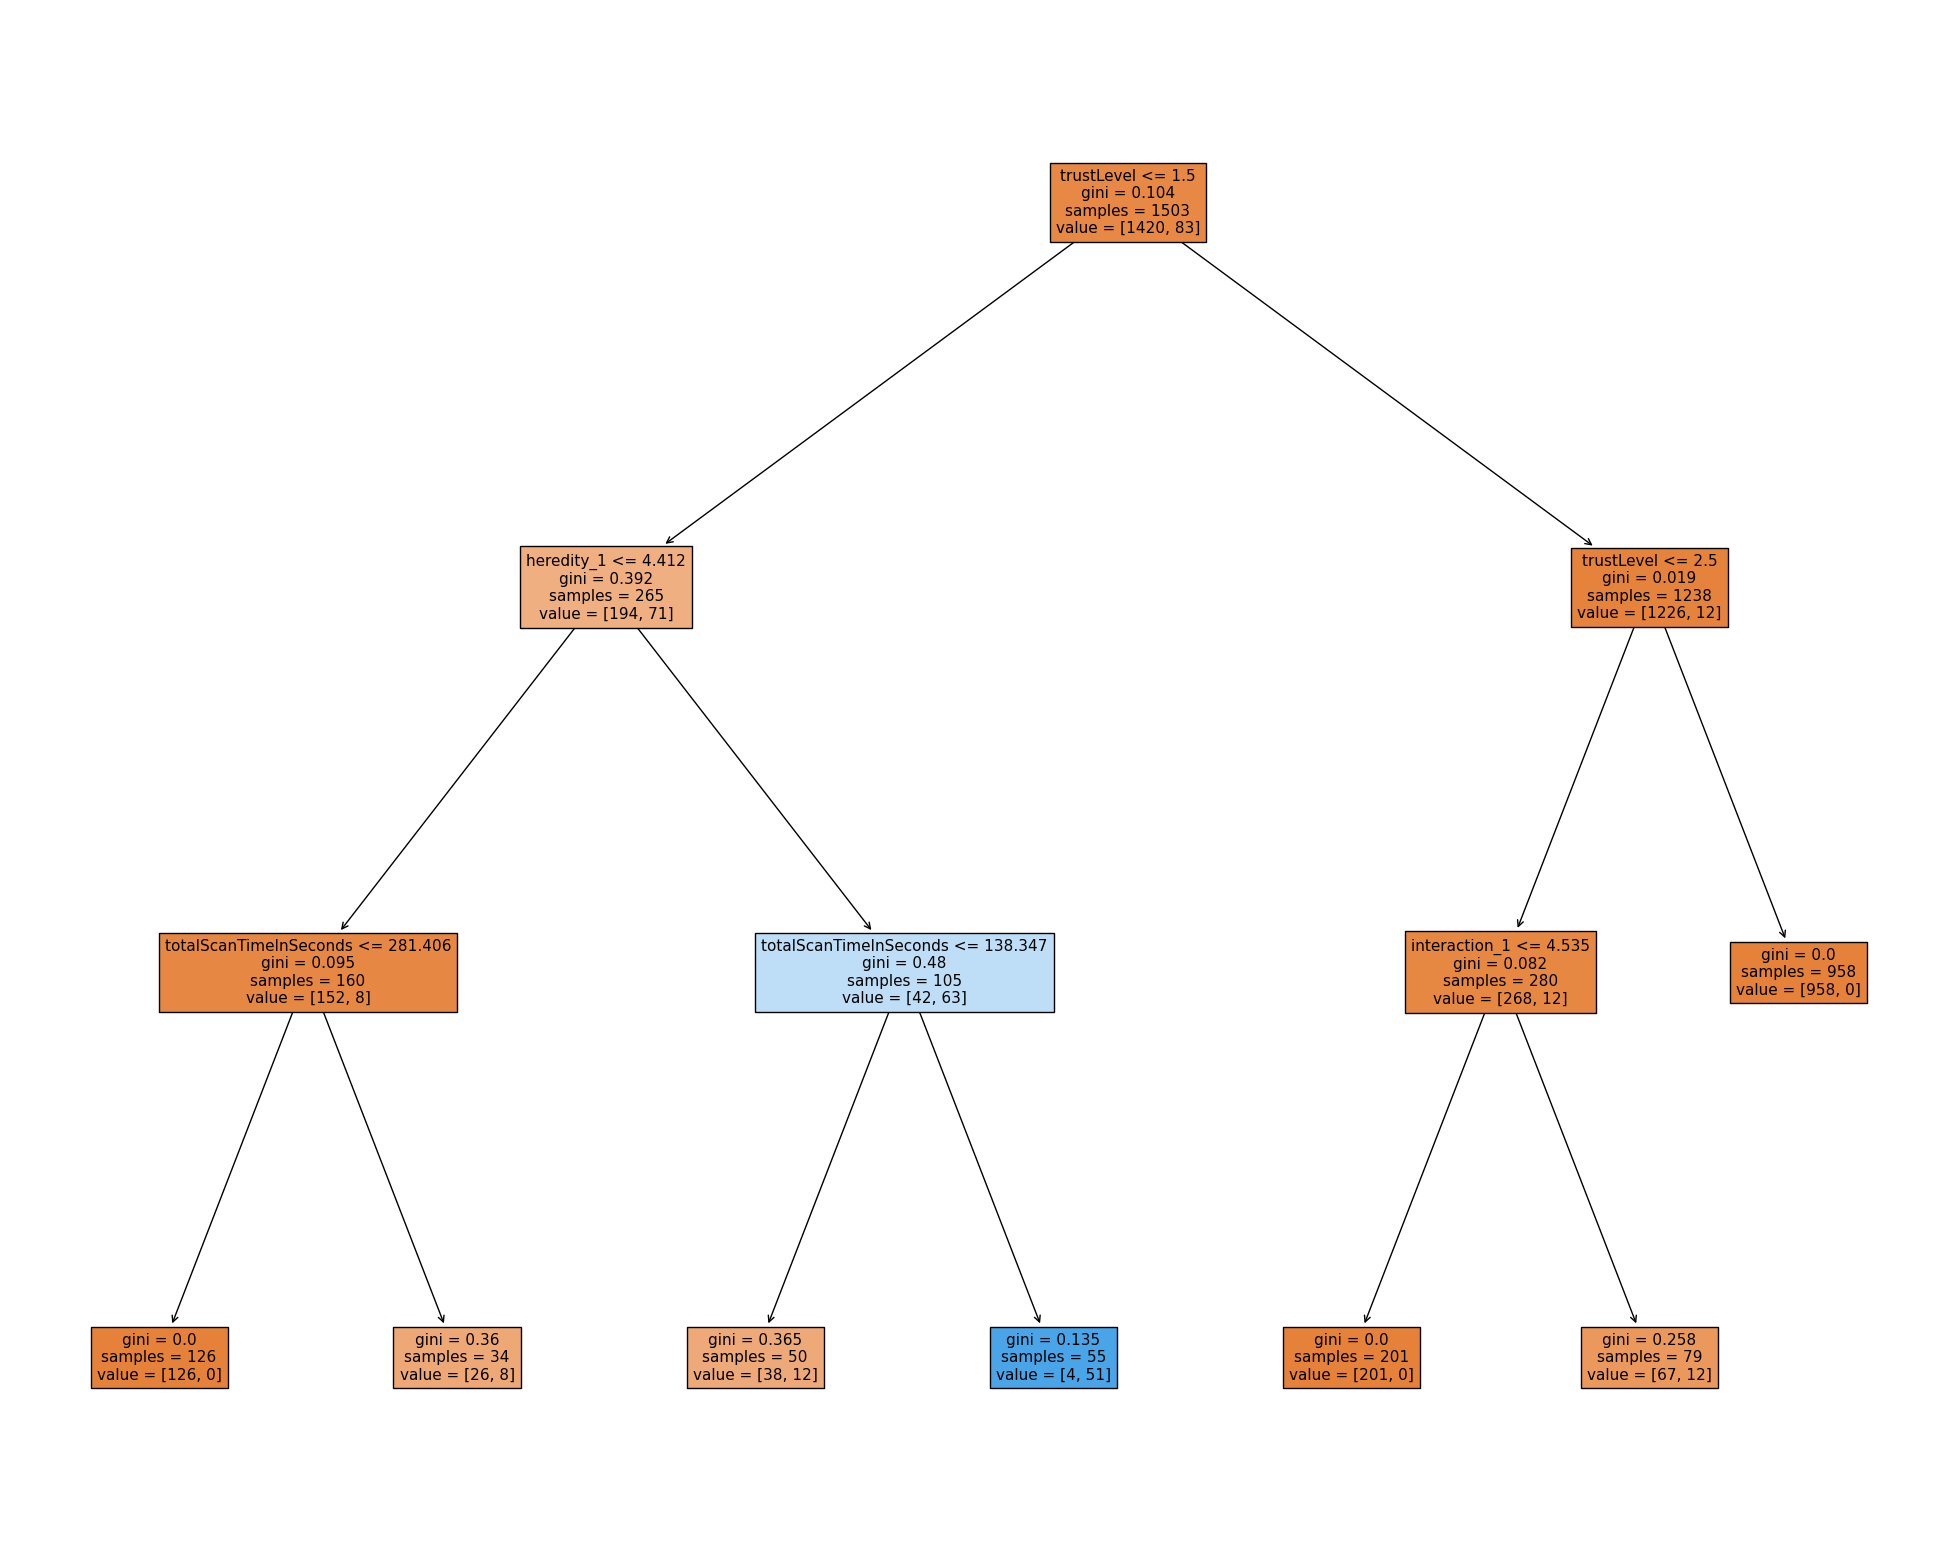

In [20]:
# defining input and target variables
x = train.drop(columns = 'fraud', axis = 1)
y = train['fraud']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

# building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

In [22]:
# engineering by decision tree
train['DT_1'] = np.where((train['trustLevel'] <= 1.5) & (train['heredity_1'] <= 4.412) & (train['totalScanTimeInSeconds'] <= 281.406), 1, 0)
test['DT_1'] = np.where((test['trustLevel'] <= 1.5) & (test['heredity_1'] <= 4.412) & (test['totalScanTimeInSeconds'] <= 281.406), 1, 0)